## Summary Notebook
### Western v. Eastern Population Data Comparisons


I have been having issues combining data from western (Korean spawning aggregates) and eastern (AK / CAN / WashCoast spawning aggregates) Pacific cod populations. For an overview of the data analysis pipeline to combine these data sets, see [Stacks pipeline synthesis notebook](https://github.com/mfisher5/PCod-Compare-repo/blob/master/notebooks/Stacks%20pipeline%20synthesis.ipynb). 

The common problem that I seem to be running into is missing data in the eastern samples. Data is systematically missing - in all eastern individuals at certain loci. 

I have gone through several steps to attempt to remedy this issue, detailed below. 

**Parameters in Original Analysis**
1. [Reference Genome](#refgenome)
2. [Original stacks run - uncorrected genotypes](#orig)
3. [Original stacks run - Corrected genotypes](#orig-corrected)
<br>
<br>

**Troubleshooting**
1. [Exploring missing data in original run](#md-batch4)
2. [Simulation: Lowering stack depth for genotyping](#lowdepth-test)
3. [Lowering `r` Parameter in Populations - batch 8](#batch8)
4. [Exploring missing data in batch 8](#md-batch8)
5. [Lowering `r` and `m` Parameter in Populations - batch 8 p.2](#batch8-m3)
6. [Filtering Individuals First - batch 8 p.3](#batch8-individ)
7. iPyrad (in progress)



After reviewing all that I have done, I've come up with the following summary: 

- Using a less stringent missing data filter for individuals and loci (0.50 instead of 0.30) is necessary 

- Using a lower stack depth (m = 3) may be necessary to increase final number of loci retained. *However,* this would definitely require using stacks genotypes, uncorrected. My worry with this is that when I use uncorrected stacks genotypes, I (a) get a higher proportion of loci *not* genotyped in individuals *despite* adequate stack depth, and (b) get a higher proportion of loci systematically missing in the eastern population. 

- I'd like to look into the 3-7% loci missing systematically across eastern population, to see if there is a chromosomal inversion here. 

- Something else to keep in mind - I'm getting *super* low Fis values in batch 4 using Marine's correction script (nearly all are negative). See [Batch 4 - Fis notebook]().





<br>
<br>
______________________________


<a id='refgenome'></a>
### Reference genome

I am using a reference genome assembled de novo using only Korean samples. This reference genome was used successfully in an analysis which only included Korean samples, and resulted in a final data set with ~ 5,000 loci. 

For details, see [Reference Genome notebook](https://github.com/mfisher5/PCod-Korea-repo/blob/master/notebooks/Reference%20Genome.ipynb)

To build the reference genome I used the following parameters: 


**ustacks:**

`-r` 
`-d `
`-m 10 `
`-M 3 `
`--model_type bounded `

<br>
**cstacks:**

`-n 3 `

<br>
**populations:**

`-t 36 `
`-r 0.75 `
`-m 10 `

<br>
**bowtie filtering:**

`bowtie -f -v 3 --sam --sam-nohead \`
`batch_3 \`
`unfilteredBOWTIE.fa \`
`batch_3_BOWTIEout.sam`

<br>
**blast filtering:**

After aligning to the blast database, I kept only loci that aligned only to themselves, or best aligned to themselves. 

<br>
**final bowtie filtering:**

I kept only loci that aligned once. 



<br>


<br>

<a id='orig'></a>
### Original run ("batch 4"), Stacks genotypes uncorrected

My original run of stacks started with eastern and western samples trimmed to 92 base pairs (eastern - from 100bp sequences; western - from 150bp sequences). 

**Bowtie: aligning fastq files to reference**

`-q`
`-v 3`
`-norc`

To see graphical comparisons of the # of reads aligned in AK v. KOR samples, see [Stacks batch 1 - AK alignment notebook](https://github.com/mfisher5/PCod-Compare-repo/blob/master/notebooks/Stacks%20batch%201%20-%20AK%20data%20alignment.ipynb). 

<br>
**trimming .sam files for Korean samples**
I aligned my original Korean fastq files, which were 142 bp long. So I went into the .sam files to trim alignments down to 92 bp. 

<br>
**pstacks**

`-m 3 `
`-p 6 `
`--model_type bounded `
`--bound_high 0.05`

<br>
**cstacks**

`-n 1`
10 individuals per population used to produce catalog. 

<br>
**populations**

`-t 36`
`-r 0.8`
`-p 3`
`-m 10`
`--write_random_snp`

<br>
** filtering steps**

1. Filtered for MAF
2. Filtered out loci with missing data (cutoff 0.50)
3. Filtered out individuals with missing data (cutoff 0.50)
4. Filtered out loci out of HWE

See % missing genotypes per locus / per individual in [Stacks batch 4 - notebook 3]()


** final # of loci:** 2454

** final # of individuals:** 636


<br>

** Stacks genepop output: Number of Loci per Individual **

Note that this code is also saved in the script: [count_loci_perindivid_stacksgenepop.py]()

In [5]:
cd ../stacks_b4_wgenome

/mnt/hgfs/PCod-Compare-repo/stacks_b4_wgenome


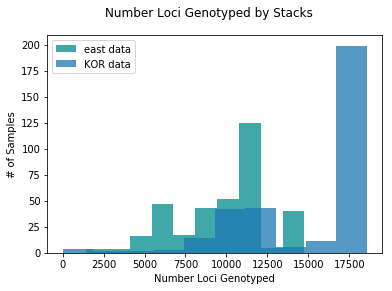

In [12]:
## get counts of loci per individual ##
# define population indices by region 
KOR_indices = range(1,10)
east_indices = range(10,18)

pop_num = 0 #set first population index
nloci_KOR = [] #initiate list for west pops
nloci_east = [] #initiate list for east pops

# open genepop file
genepop = open("batch_4_genepop.txt", "r")
genepop.readline() # header line
loci = genepop.readline()
total_loci = len(loci.strip().split(","))

# go through lines in genepop and add nloci to region-specific list
for line in genepop:
    if "pop" in line:
        pop_num += 1
    else:
        genotypes = line.strip().split("\t")[1:]
        missing_loci = genotypes.count("0000")
        nloci_individ = total_loci - missing_loci
        if pop_num in KOR_indices:
            nloci_KOR.append(nloci_individ)
        elif pop_num in east_indices:
            nloci_east.append(nloci_individ)
        else:
            print "Unknown population."
    
## plot ##
import matplotlib.pyplot as plt
import numpy as np
plt.hist(nloci_east, alpha = 0.75, color = "darkcyan", label = "east data")
plt.hist(nloci_KOR, alpha = 0.75, label = "KOR data")
plt.suptitle("Number Loci Genotyped by Stacks")
plt.xlabel("Number Loci Genotyped")
plt.ylabel("# of Samples")
plt.legend(loc='upper left')
plt.show()

In [13]:
plt.close()

** Stacks genepop output: Number of Loci missing from all Alaskan populations **

In [60]:
!python ../scripts/transpose_genepop.py \
batch_4_genepop.txt \
batch_4_genepop_transposed.txt

680
19217


In [68]:
## extract loci missing across alaskan individuals ##
# open genepop file
infile = open("batch_4_genepop_transposed.txt", "r")
infile.readline() # header

# get list of loci missing systematically in eastern pops
loci_missing = []
for line in infile:
    genotypes = line.strip().split()[1:]
    if len(genotypes) < 326:
        print line.strip().split()[0]
    kor_genos = genotypes[0:326]
    east_genos = genotypes[326:]
    p_kor_missing = float(kor_genos.count("0000")) / float(len(kor_genos))
    p_east_missing = float(east_genos.count("0000")) / float(len(east_genos))
    if p_kor_missing < 0.30 and p_east_missing > 0.95:
        loci_missing.append(line.strip().split(" ")[0])
infile.close()
print "There are ", len(loci_missing), " loci missing systematically across eastern population"
print "This comprises ", float(len(loci_missing)) / float(19216) * 100, " percent of total loci."

There are  1400  loci missing systematically across eastern population
This comprises  7.28559533722  percent of total loci.


<br>
<br>
**MAF filtered Stacks genepop output: Number of Loci missing from all Alaskan populations  **


In [85]:
## extract loci missing across alaskan individuals ##
# open genepop file
infile = open("batch_4_filteredMAF.txt", "r")
infile.readline() # header

# get list of loci missing systematically in eastern pops
loci_missing = []
for line in infile:
    genotypes = line.strip().split()[1:]
    if len(genotypes) < 326:
        print line.strip().split()[0]
    kor_genos = genotypes[0:326]
    east_genos = genotypes[326:]
    p_kor_missing = float(kor_genos.count("0000")) / float(len(kor_genos))
    p_east_missing = float(east_genos.count("0000")) / float(len(east_genos))
    if p_kor_missing < 0.30 and p_east_missing > 0.95:
        loci_missing.append(line.strip().split(" ")[0])
infile.close()
print "There are ", len(loci_missing), " loci missing systematically across eastern population"
print "This comprises ", float(len(loci_missing)) / float(4000) * 100, " percent of total loci."

There are  283  loci missing systematically across eastern population
This comprises  7.075  percent of total loci.


<br>
<br>
<a id='orig-corrected'></a>
### Original run ("batch 4"), Corrected genotypes

** filtering steps**

1. Corrected Genotypes according to Marine's script
2. Filtered for MAF
3. Filtered out loci with missing data (cutoff 0.50)
4. Filtered out individuals with missing data (cutoff 0.30)
5. Filtered out loci out of HWE

See % missing genotypes per locus / per individual in [Stacks batch 4 - nb5 ]()


** final # of loci:** 3909

** final # of individuals:** 


<br>

** Corrected Genotypes: Loci genotyped per individual **

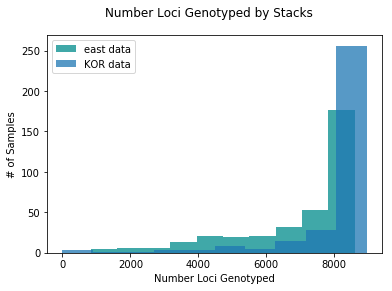

In [72]:
## get counts of loci per individual ##

nloci_KOR = [] #initiate list for west pops
nloci_east = [] #initiate list for east pops

# open genepop file
genepop = open("batch_4.CorrectedGenotypes_biallelic_genepop.txt", "r")
genepop.readline() # header line
loci = genepop.readline()
total_loci = len(loci.strip().split())

# go through lines in genepop and add nloci to region-specific list
count = 0
for line in genepop:
    count += 1
    genotypes = line.strip().split("\t")[1:]
    missing_loci = genotypes.count("0000")
    nloci_individ = total_loci - missing_loci
    if count < 326:
        nloci_KOR.append(nloci_individ)
    else:
        nloci_east.append(nloci_individ)
    
## plot ##
import matplotlib.pyplot as plt
import numpy as np
plt.hist(nloci_east, alpha = 0.75, color = "darkcyan", label = "east data")
plt.hist(nloci_KOR, alpha = 0.75, label = "KOR data")
plt.suptitle("Number Loci Genotyped by Stacks")
plt.xlabel("Number Loci Genotyped")
plt.ylabel("# of Samples")
plt.legend(loc='upper left')
plt.show()

In [80]:
plt.close()

**Corrected Genotypes: Number of Loci missing from all Alaskan populations**


In [84]:
## extract loci missing across alaskan individuals ##
# open genepop file
infile = open("batch_4.CorrectedGenotypes_biallelic_genepop_TRANSPOSED.txt", "r")
infile.readline() # header

# get list of loci missing systematically in eastern pops
loci_missing = []
for line in infile:
    genotypes = line.strip().split()[1:]
    if len(genotypes) < 326:
        print line.strip().split()[0]
    kor_genos = genotypes[0:326]
    east_genos = genotypes[326:]
    p_kor_missing = float(kor_genos.count("0000")) / float(len(kor_genos))
    p_east_missing = float(east_genos.count("0000")) / float(len(east_genos))
    if p_kor_missing < 0.30 and p_east_missing > 0.95:
        loci_missing.append(line.strip().split(" ")[0])
infile.close()
print "There are ", len(loci_missing), " loci missing systematically across eastern population"
print "This comprises ", float(len(loci_missing)) / float(11198) * 100, " percent of total loci."

There are  310  loci missing systematically across eastern population
This comprises  2.76835149134  percent of total loci.


** MAF filtered Corrected Genotypes: Loci genotyped per individual **

In [79]:
!python ../scripts/transpose_MB_MAFfiltered.py \
batch_4_MB_filteredMAF.txt \
batch_4_MB_filteredMAF_transposed.txt

5430
680


*note - had to manually fix the last line of file to remove '\n'*

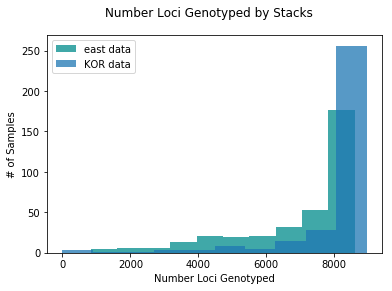

In [81]:
## get counts of loci per individual ##

nloci_KOR = [] #initiate list for west pops
nloci_east = [] #initiate list for east pops

# open genepop file
genepop = open("batch_4.CorrectedGenotypes_biallelic_genepop.txt", "r")
genepop.readline() # header line
loci = genepop.readline()
total_loci = len(loci.strip().split())

# go through lines in genepop and add nloci to region-specific list
count = 0
for line in genepop:
    count += 1
    genotypes = line.strip().split("\t")[1:]
    missing_loci = genotypes.count("0000")
    nloci_individ = total_loci - missing_loci
    if count < 326:
        nloci_KOR.append(nloci_individ)
    else:
        nloci_east.append(nloci_individ)
    
## plot ##
import matplotlib.pyplot as plt
import numpy as np
plt.hist(nloci_east, alpha = 0.75, color = "darkcyan", label = "east data")
plt.hist(nloci_KOR, alpha = 0.75, label = "KOR data")
plt.suptitle("Number Loci Genotyped by Stacks")
plt.xlabel("Number Loci Genotyped")
plt.ylabel("# of Samples")
plt.legend(loc='upper left')
plt.show()

In [82]:
plt.close()

**MAF filtered Corrected Genotypes: Number of Loci missing from all Alaskan populations**

In [75]:
pwd

u'/mnt/hgfs/PCod-Compare-repo/stacks_b4_wgenome'

In [83]:
## extract loci missing across alaskan individuals ##
# open genepop file
infile = open("batch_4_MB_filteredMAF.txt", "r")
infile.readline() # header

# get list of loci missing systematically in eastern pops
loci_missing = []
for line in infile:
    genotypes = line.strip().split(",")[1:]
    if len(genotypes) < 326:
        print line.strip().split()[0]
    kor_genos = genotypes[0:326]
    east_genos = genotypes[326:]
    p_kor_missing = float(kor_genos.count("0000")) / float(len(kor_genos))
    p_east_missing = float(east_genos.count("0000")) / float(len(east_genos))
    if p_kor_missing < 0.30 and p_east_missing > 0.95:
        loci_missing.append(line.strip().split(" ")[0])
infile.close()
print "There are ", len(loci_missing), " loci missing systematically across eastern population"
print "This comprises ", float(len(loci_missing)) / float(5431) * 100, " percent of total loci."

There are  184  loci missing systematically across eastern population
This comprises  3.38795801878  percent of total loci.


<br>
<br>
<br>


<a id='md-batch4'></a>


### Missing Data Explorations - Orig run (batch 4), Corrected Genotypes

See [Stacks batch 4 - missing data notebook]()

1. SNP position v. Missing Data: No apparent trend

2. Of the loci missing systematically in eastern pop, what proportion are identified in .matches files? : Histogram showed average of > .50

3. Of the loci missing systematically in eastern pop but identified in the .matches files, what is the stack depth recorded in the matches files for each individual?: Histogram showed that although majority had stack depth < 10, there were some with high stack depth that were note genotyped


** Depth of each locus in sam files**

Although batch 3 was run with samples not trimmed to the correct length, I think that several visuals produced from my data exploration for this batch are interesting. This includes: 

1. Number of reads assigned to each reference locus after bowtie alignment
2. Number of reference loci aligned to in korean v. eastern populations

See [Explore Missing Genotypes in AK Samples - SAM Mapped Reads]()

<br>
<br>
<br>

<a id='lowdepth-test'></a>

### Genotyping with a stack depth of 3

I ran a test to see how genotypes compare when they are called with a minimum stack depth of 3, less data, instead of 10, more data. 

To do this, I took a subset (n = 50) of my Korean samples, and then subsampled reads from their alignment files so that I only retained 50% of the original data (to simulate the eastern population's files). Note that even when I only took 50% of my Korean data, many individuals *still* had more data than the eastern samples. 

I first used stacks to genotyped the individuals, and then used Marine's correction script. 

I did the following analyses for both corrected and uncorrected genotypes: 

1. Of the loci that showed up in both stacks runs ("shared" loci), what proportion were genotyped from the original data files? What proportion were genotyped from the subsampled files?
2. Of the shared loci, what proportion did *not* match?
3. Of the shared loci that had genotypes that did *not* match, how frequently was this mismatch due to missing data in one or the other stacks runs?
4. Of the shared loci that did *not* match, why did they differ? (het --> hom or hom --> het)?
4. Were certain loci driving the higher proportion of mismatches?


For original Jupyter notebooks, see folder labeled [batch3_1]()

Graphs are also summarized in [Evernote, Summary:Subset Korean Data](http://www.evernote.com/l/AoqW-Fjzz_NJKbBw_cohu4QgDNkdA5bx2lM/)

Major conclusions: 
- with corrected genotypes, a mean of 8% of loci which were genotyped in both runs did NOT have matching genotypes. Weirdly enough, this was mostly because of switching from one form of homozygote to the other. approximately 4% of this difference could be attributed to het --> hom or hom --> het
- with uncorrected genotypes, this number was much lower - a mean of 0.2% of loci which were genotyped in both runs did NOT have matching genotypes. most, if not all, of this was due to hom --> het and het --> hom switching. 

<br>
<br>

### Lowering r = 0.8 to r = 0.5 (batch 8) 


<br>

I ran this with a `populations` m = 10 and then Marine's genotype correction script.


** Corrected genotypes: Number of Loci per Individual **

In [1]:
cd ../

/mnt/hgfs/PCod-Compare-repo


In [2]:
cd stacks_b8_wgenome_r05/populations_m10/

/mnt/hgfs/PCod-Compare-repo/stacks_b8_wgenome_r05/populations_m10


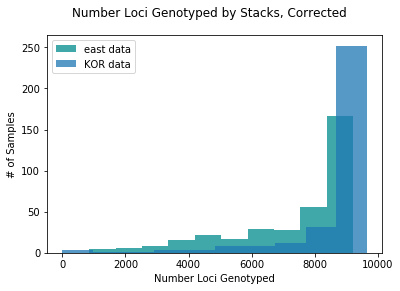

In [6]:
## get counts of loci per individual ##

nloci_KOR = [] #initiate list for west pops
nloci_east = [] #initiate list for east pops

# open genepop file
genepop = open("batch_8.CorrectedGenotypes_biallelic_genepop.txt", "r")
genepop.readline() # header line
loci = genepop.readline()
total_loci = len(loci.strip().split())

# go through lines in genepop and add nloci to region-specific list
count = 0
for line in genepop:
    count += 1
    genotypes = line.strip().split("\t")[1:]
    missing_loci = genotypes.count("0000")
    nloci_individ = total_loci - missing_loci
    if count < 326:
        nloci_KOR.append(nloci_individ)
    else:
        nloci_east.append(nloci_individ)
    
## plot ##
import matplotlib.pyplot as plt
import numpy as np
plt.hist(nloci_east, alpha = 0.75, color = "darkcyan", label = "east data")
plt.hist(nloci_KOR, alpha = 0.75, label = "KOR data")
plt.suptitle("Number Loci Genotyped by Stacks, Corrected")
plt.xlabel("Number Loci Genotyped")
plt.ylabel("# of Samples")
plt.legend(loc='upper left')
plt.show()

In [7]:
plt.close()

** Corrected Genotypes: Number of Loci missing systematically from AK/CAN populations**

In [5]:
## extract loci missing across alaskan individuals ##
# open genepop file
infile = open("batch_8.CorrectedGenotypes_biallelic_genepop_TRANSPOSED.txt", "r")
infile.readline() # header

# get list of loci missing systematically in eastern pops
loci_missing = []
for line in infile:
    genotypes = line.strip().split()[1:]
    if len(genotypes) < 326:
        print line.strip().split()[0]
    kor_genos = genotypes[0:326]
    east_genos = genotypes[326:]
    p_kor_missing = float(kor_genos.count("0000")) / float(len(kor_genos))
    p_east_missing = float(east_genos.count("0000")) / float(len(east_genos))
    if p_kor_missing < 0.30 and p_east_missing > 0.95:
        loci_missing.append(line.strip().split(" ")[0])
infile.close()
print "There are ", len(loci_missing), " loci missing systematically across eastern population"

print "This comprises ", float(len(loci_missing)) / float(11198) * 100, " percent of total loci."

There are  334  loci missing systematically across eastern population
This comprises  2.98267547776  percent of total loci.



<br>
<br>

<a id='md-batch8'></a>

### Exploring missing data in batch 8 - m10 / -r 0.5, corrected genotypes

I wanted to look into why I still had relatively few genotypes after running batch 8 with a minimum stack depth (`-m`) of 10, with genotypes corrected by Marine's script. 

<br>

To do so, I did the following in the Jupyter notebook [Batch 8 - missing data](https://github.com/mfisher5/PCod-Compare-repo/blob/master/notebooks/Batch%208%20-%20missing%20data.ipynb):
1. Plotted the missing data per individual after genotype correction and MAF filtering. I broke histograms down by population, so that I could see the difference in AK/CAN v. KOR samples. 
2. Plotted the number of loci found in each individual for the following steps: 
    * genepop out of populations, with stacks calling genotypes
    * unfiltered genepop, corrected with Marine's script
    * sstacks, with the original `-m 10` parameter
    * sstacks, with a minimum stack depth of 5
    
    
    
** Main takeaways:**
1. Plotting after genotype correction and MAF filtering: AK/CAN samples are definitely missing more genotypes per individual than Korean samples - they look similar to my Korean samples that had low DNA quantities / quality. 
2. The decrease in loci genotyped per sample (i.e. increase in missing data) appears to first occur at sstacks; this suggests that my depth parameter is the problem. 

<br>
<br>
<a id='batch8-m3'></a>

### Batch 8 part 2: `-m 3` and uncorrected genotypes


Given what I found above, I decided to run populations with a crazy low stack depth of 3. Because of the simulations that I did with the Korean data, and because her script was designed for stack depths of 5 / 10, I did not use Marine's correction script.

In [1]:
cd ../stacks_b8_wgenome_r05

/mnt/hgfs/PCod-Compare-repo/stacks_b8_wgenome_r05


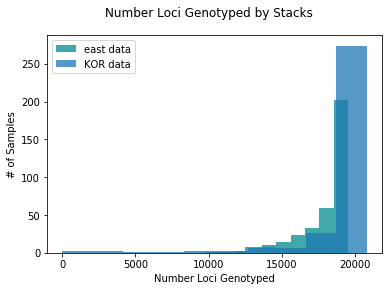

In [2]:
## get counts of loci per individual ##
# define population indices by region 
KOR_indices = range(1,10)
east_indices = range(10,18)

pop_num = 0 #set first population index
nloci_KOR = [] #initiate list for west pops
nloci_east = [] #initiate list for east pops

# open genepop file
genepop = open("batch_8.genepop", "r")
genepop.readline() # header line
loci = genepop.readline()
total_loci = len(loci.strip().split(","))

# go through lines in genepop and add nloci to region-specific list
for line in genepop:
    if "pop" in line:
        pop_num += 1
    else:
        genotypes = line.strip().split("\t")[1:]
        missing_loci = genotypes.count("0000")
        nloci_individ = total_loci - missing_loci
        if pop_num in KOR_indices:
            nloci_KOR.append(nloci_individ)
        elif pop_num in east_indices:
            nloci_east.append(nloci_individ)
        else:
            print "Unknown population."
    
## plot ##
import matplotlib.pyplot as plt
import numpy as np
plt.hist(nloci_east, alpha = 0.75, color = "darkcyan", label = "east data")
plt.hist(nloci_KOR, alpha = 0.75, label = "KOR data")
plt.suptitle("Number Loci Genotyped by Stacks")
plt.xlabel("Number Loci Genotyped")
plt.ylabel("# of Samples")
plt.legend(loc='upper left')
plt.show()

In [3]:
plt.close()

** Stacks genepop output: Number of Loci missing from all Alaskan populations **

In [4]:
!python ../scripts/transpose_genepop.py \
batch_8.genepop \
batch_8_genepop_transposed.txt

680
21019


In [5]:
## extract loci missing across alaskan individuals ##
# open genepop file
infile = open("batch_8_genepop_transposed.txt", "r")
infile.readline() # header

# get list of loci missing systematically in eastern pops
loci_missing = []
for line in infile:
    genotypes = line.strip().split()[1:]
    if len(genotypes) < 326:
        print line.strip().split()[0]
    kor_genos = genotypes[0:326]
    east_genos = genotypes[326:]
    p_kor_missing = float(kor_genos.count("0000")) / float(len(kor_genos))
    p_east_missing = float(east_genos.count("0000")) / float(len(east_genos))
    if p_kor_missing < 0.30 and p_east_missing > 0.95:
        loci_missing.append(line.strip().split(" ")[0])
infile.close()
print "There are ", len(loci_missing), " loci missing systematically across eastern population"
print "This comprises ", float(len(loci_missing)) / float(19216) * 100, " percent of total loci."

There are  1103  loci missing systematically across eastern population
This comprises  5.74000832639  percent of total loci.


<br>
<br>
<br>

<a id='batch8-individ'></a>

### Batch 8 p.3 - filter individuals before loci  (`-m 10`, corrected)

In my filtering process, I filter loci for missing data BEFORE I filter individuals for missing data. Given the results from my exploration into missing data above, I'm going to filter individuals first. Since I'm pooling populations on the same side of the Pacific, it shouldn't be too terrible even if I have to remove a decent number of individuals. 

*Note that the following loci counts are pre-HWE*

By filtering individuals filtering individuals first:

|---individual filter---|---loci filter---|---retained loci---|
|:---------------------:|:---------------:|:-----------------:|
|----0.50---|---0.50---|---4722---|
|---0.30---|---0.50---|---4856---|


Refer to the end of Jupyter notebook [Stacks batch 8 - MB filter](https://github.com/mfisher5/PCod-Compare-repo/blob/master/notebooks/batch8_pipeline/Stacks%20batch%208%20-%20MB%20Filter.ipynb)